# Importing Main Libraries

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from google.colab import files


# Reading the Dataset

In [ ]:
dataset = pd.read_excel("hourly_w-night_weather-dataset_chronological-order_w-night.xlsx")
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Datetime'] = dataset['Date'] + pd.to_timedelta(dataset['Hour'],unit = 'h')
dataset['Day'] = pd.to_datetime(dataset['Date']).dt.day
dataset['Year'] = pd.to_datetime(dataset['Date']).dt.year
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month

og_dataset = dataset.copy()
dataset = dataset[dataset['Solar energy'] != 0]
print(dataset['Day'])
features = ['Cloud coverage','Visibility','Temperature','Dew point','Relative humidity','Wind speed','Station pressure','Altimeter']

7         1
8         1
9         1
10        1
11        1
         ..
15061    28
15062    28
15063    28
15064    28
15065    28
Name: Day, Length: 8424, dtype: int32


# **Feature Engineering**

In [ ]:
dataset = dataset.drop(columns=['(Inverter)'], errors='ignore')

for lag in range(1, 4):
    dataset[f'Solar energy lag{lag}'] = dataset['Solar energy'].shift(lag)


for lag in range(1, 4):
    for feature in features:
        dataset[f'{feature} lag{lag}'] = dataset[feature].shift(lag)
dataset['sin_hour'] = np.sin(2 * np.pi * dataset['Hour'] / 24)
dataset['cos_hour'] = np.cos(2 * np.pi * dataset['Hour'] / 24)
dataset['sin_month'] = np.sin(2 * np.pi * dataset['Month'] / 12)
dataset['cos_month'] = np.cos(2 * np.pi * dataset['Month'] / 12)


dataset = dataset.dropna().reset_index(drop=True)
print(dataset)


           Date  Hour  Cloud coverage  Visibility  Temperature  Dew point  \
0    2016-02-01    10            0.46        10.0         3.15       1.07   
1    2016-02-01    11            0.42        10.0         4.50       1.05   
2    2016-02-01    12            0.00        10.0         6.16       1.26   
3    2016-02-01    13            0.00        10.0         7.56       1.41   
4    2016-02-01    14            0.00        10.0         8.47       0.63   
...         ...   ...             ...         ...          ...        ...   
8416 2017-10-28    13            1.00        10.0         4.50       0.85   
8417 2017-10-28    14            1.00        10.0         4.72      -0.50   
8418 2017-10-28    15            1.00        10.0         4.18      -0.04   
8419 2017-10-28    16            1.00        10.0         3.77       0.00   
8420 2017-10-28    17            1.00        10.0         3.59      -0.79   

      Relative humidity  Wind speed  Station pressure  Altimeter  ...  \
0 

In [ ]:
daily_average_solar_energy = dataset.groupby('Date')['Solar energy'].mean()
monthly_average_solar_energy = dataset.groupby('Month')['Solar energy'].mean()
unique_months = np.unique(dataset['Month'])
unique_dates = np.unique(dataset['Date'])

In [ ]:
print(daily_average_solar_energy)
print(monthly_average_solar_energy)

Date
2016-02-01    2374.913750
2016-02-02     165.011818
2016-02-03     232.279167
2016-02-04    2648.307273
2016-02-05     802.820000
                 ...     
2017-10-24     497.275455
2017-10-25     817.395000
2017-10-26    2323.182500
2017-10-27    1323.085833
2017-10-28     605.904545
Name: Solar energy, Length: 626, dtype: float64
Month
1      692.674357
2     1575.488834
3     1583.591985
4     1695.689102
5     1662.568265
6     1734.419946
7     1682.490890
8     1831.409777
9     1971.086507
10    1510.164312
11    1478.230276
12     821.630690
Name: Solar energy, dtype: float64


# Plotting Features

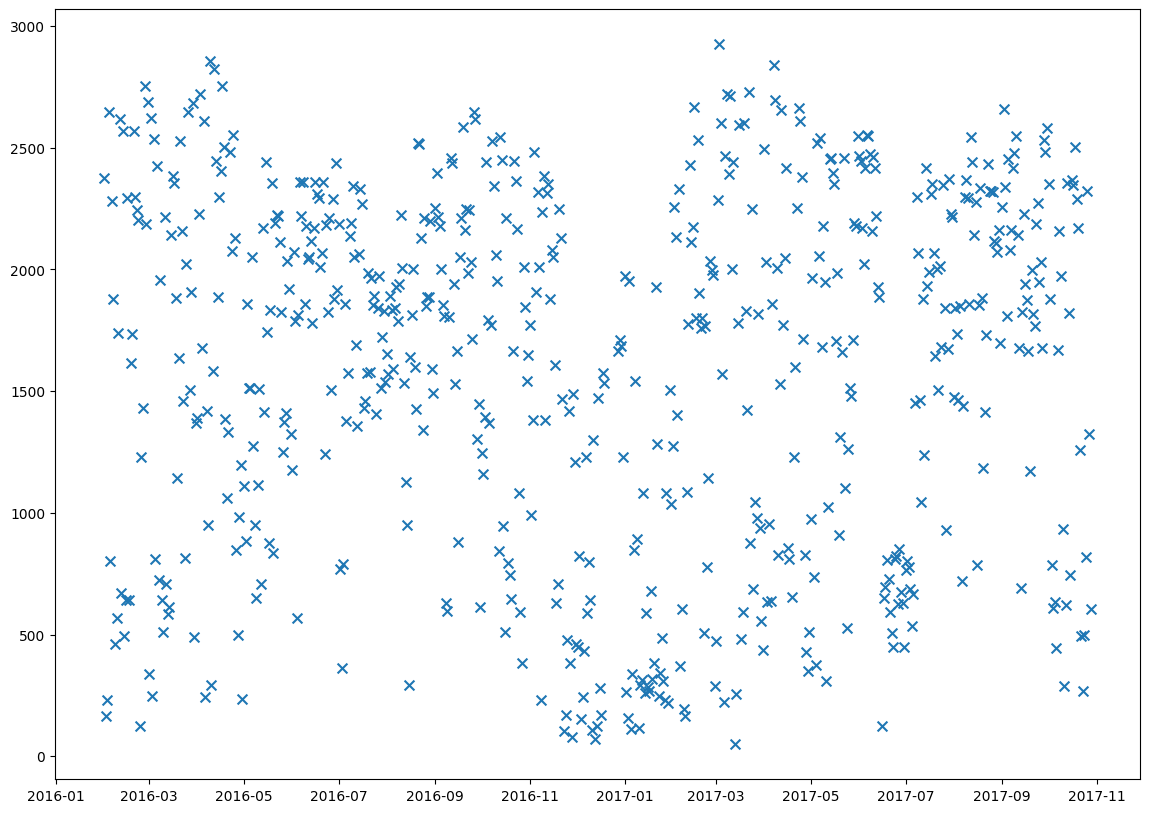

In [ ]:
plt.figure(figsize=(14,10))
plt.scatter(unique_dates,daily_average_solar_energy,marker='x',s=50)
plt.show()

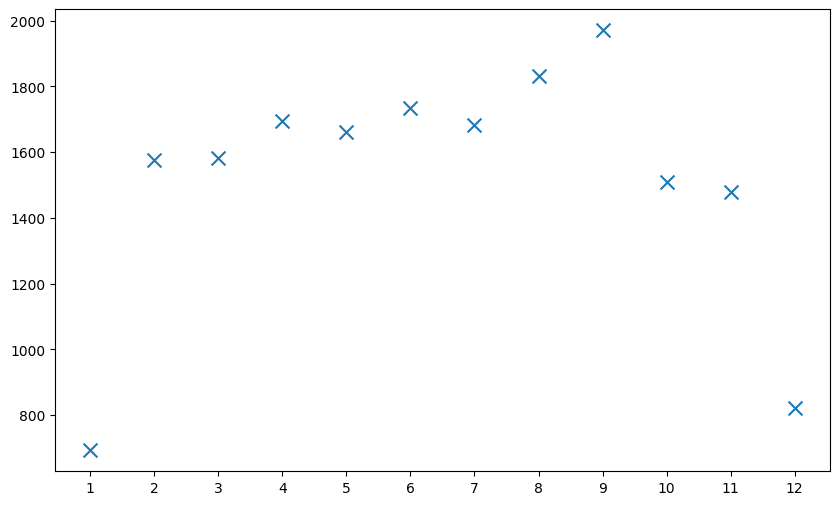

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(unique_months,monthly_average_solar_energy,marker='x',s=100)
plt.xticks(np.arange(1,13,1))
plt.show()

In [ ]:
# plt.figure(figsize=(12,10))
# for i in range(1,len(dataset)-23,24):
#   #print(f"{i}, date: {dataset['Date'][i]} hour: {dataset['Hour'][i+11]}, Solar Energy: {dataset['Solar energy'][i+11]}")
#   plt.scatter(dataset['Hour'][i:i+24],dataset['Solar energy'][i:i+24])
# plt.xticks(np.arange(1,25,1))
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))
# print(dataset.iloc[24,:])

# plt.scatter(dataset['Hour'][25:49],dataset['Solar energy'][25:49])
# plt.xticks(np.arange(1,25,1))
# plt.show()

In [ ]:
# print(dataset)

In [ ]:
# for i in features:
#   plt.figure(figsize=(14,10))
#   plt.scatter(dataset['Datetime'],dataset[i],marker= "x")
#   plt.title(i)
#   plt.show()

Based on these plots and data We chose to use:
min max scaling for 0,1,4;
standard scaling for 2,3,5,6,7

In [ ]:
print(dataset)

           Date  Hour  Cloud coverage  Visibility  Temperature  Dew point  \
0    2016-02-01    10            0.46        10.0         3.15       1.07   
1    2016-02-01    11            0.42        10.0         4.50       1.05   
2    2016-02-01    12            0.00        10.0         6.16       1.26   
3    2016-02-01    13            0.00        10.0         7.56       1.41   
4    2016-02-01    14            0.00        10.0         8.47       0.63   
...         ...   ...             ...         ...          ...        ...   
8416 2017-10-28    13            1.00        10.0         4.50       0.85   
8417 2017-10-28    14            1.00        10.0         4.72      -0.50   
8418 2017-10-28    15            1.00        10.0         4.18      -0.04   
8419 2017-10-28    16            1.00        10.0         3.77       0.00   
8420 2017-10-28    17            1.00        10.0         3.59      -0.79   

      Relative humidity  Wind speed  Station pressure  Altimeter  ...  \
0 

# Feature Scaling

In [ ]:
min_max_features = ['Cloud coverage','Visibility','Relative humidity', 'Cloud coverage lag1','Cloud coverage lag2','Cloud coverage lag3',
                    'Visibility lag1','Visibility lag2','Visibility lag3','Relative humidity lag1','Relative humidity lag2',
                    'Relative humidity lag3']
standard_features = ['Temperature','Dew point','Wind speed','Station pressure','Altimeter','Temperature lag1','Temperature lag2','Temperature lag3','Dew point lag1',
                     'Dew point lag2','Dew point lag3','Wind speed lag1','Wind speed lag2','Wind speed lag3','Station pressure lag1','Station pressure lag2',
                     'Station pressure lag3','Altimeter lag1','Altimeter lag2','Altimeter lag3']
lagged_energy_features = ['Solar energy lag1','Solar energy lag2','Solar energy lag3']
seasonal_features = ['sin_hour','cos_hour','sin_month','cos_month']
dataset.rename(columns={'Datetime':'ds','Solar energy':'y'},inplace=True)
prophet_df = dataset.copy()

date_time_features = ['Day','Month','Hour','Year']

features = min_max_features + standard_features + lagged_energy_features + seasonal_features

In [ ]:
prophet_df.to_excel('prophet_df.xlsx')
files.download('prophet_df.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_set = prophet_df.iloc[:int(0.8*(len(prophet_df)))]
test_set = prophet_df.iloc[int(0.8*(len(prophet_df))):].reset_index(drop=True)
# print(train_set)
# print(test_set)

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 20.0, 50.0],
    # 'seasonality_mode': ['additive', 'multiplicative']
}

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(0,1))

train_set[standard_features] = standard_scaler.fit_transform(train_set[standard_features])
test_set[standard_features] = standard_scaler.transform(test_set[standard_features])
train_set[min_max_features] = min_max_scaler.fit_transform(train_set[min_max_features])
test_set[min_max_features] = min_max_scaler.transform(test_set[min_max_features])

<ipython-input-17-3c017d76bb95>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[standard_features] = standard_scaler.fit_transform(train_set[standard_features])
<ipython-input-17-3c017d76bb95>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[min_max_features] = min_max_scaler.fit_transform(train_set[min_max_features])


In [ ]:
train_set[lagged_energy_features] = np.log1p(train_set[lagged_energy_features])
test_set[lagged_energy_features] = np.log1p(test_set[lagged_energy_features])

train_set['y'] = np.log1p(train_set['y'])
test_set['y'] = np.log1p(test_set['y'])

<ipython-input-18-0d65fa8599c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[lagged_energy_features] = np.log1p(train_set[lagged_energy_features])
<ipython-input-18-0d65fa8599c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['y'] = np.log1p(train_set['y'])


In [ ]:
datetime_features = features + date_time_features
for i in datetime_features:
  print(f"{i}, type: {type(train_set[i][0])}")

Cloud coverage, type: <class 'numpy.float64'>
Visibility, type: <class 'numpy.float64'>
Relative humidity, type: <class 'numpy.float64'>
Cloud coverage lag1, type: <class 'numpy.float64'>
Cloud coverage lag2, type: <class 'numpy.float64'>
Cloud coverage lag3, type: <class 'numpy.float64'>
Visibility lag1, type: <class 'numpy.float64'>
Visibility lag2, type: <class 'numpy.float64'>
Visibility lag3, type: <class 'numpy.float64'>
Relative humidity lag1, type: <class 'numpy.float64'>
Relative humidity lag2, type: <class 'numpy.float64'>
Relative humidity lag3, type: <class 'numpy.float64'>
Temperature, type: <class 'numpy.float64'>
Dew point, type: <class 'numpy.float64'>
Wind speed, type: <class 'numpy.float64'>
Station pressure, type: <class 'numpy.float64'>
Altimeter, type: <class 'numpy.float64'>
Temperature lag1, type: <class 'numpy.float64'>
Temperature lag2, type: <class 'numpy.float64'>
Temperature lag3, type: <class 'numpy.float64'>
Dew point lag1, type: <class 'numpy.float64'>
De

# Ensemble: Random Forest

In [ ]:
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
X_train = train_set[datetime_features]
y_train = train_set['y']
X_test = test_set[datetime_features]
y_test = test_set['y']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


rf_predictions = rf_model.predict(X_test)

rf_rmse = sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest Test RMSE: {rf_rmse}")


rf_normalized_rmse = rf_rmse / np.std(y_test)
print(f"Random Forest Normalized RMSE: {rf_normalized_rmse:.2%}")

Random Forest Test RMSE: 0.4245308607465941
Random Forest Normalized RMSE: 21.89%


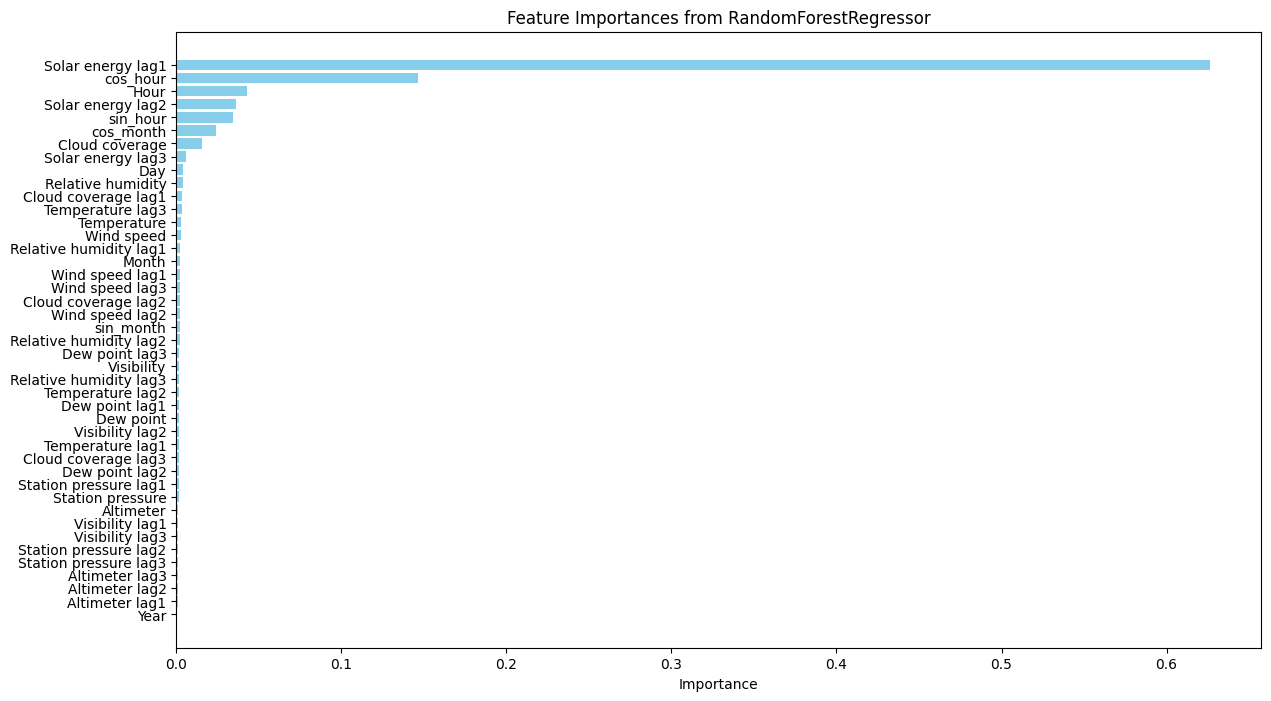

['Solar energy lag1', 'cos_hour', 'Hour', 'Solar energy lag2', 'sin_hour', 'cos_month', 'Cloud coverage', 'Solar energy lag3', 'Day', 'Relative humidity', 'Cloud coverage lag1', 'Temperature lag3', 'Temperature', 'Wind speed', 'Relative humidity lag1', 'Month']


In [ ]:
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from RandomForestRegressor')
plt.gca().invert_yaxis()
plt.show()

important_features = list(importance_df['Feature'][:16])
print(important_features)

In [ ]:
for i in important_features:
  print(f"'{i}' : {prophet_df[i].iloc[-1],}")

'Solar energy lag1' : (126.78,)
'cos_hour' : (-0.25881904510252063,)
'Hour' : (17,)
'Solar energy lag2' : (338.5,)
'sin_hour' : (-0.9659258262890683,)
'cos_month' : (0.5000000000000001,)
'Cloud coverage' : (1.0,)
'Solar energy lag3' : (728.5,)
'Day' : (28,)
'Relative humidity' : (73.72,)
'Cloud coverage lag1' : (1.0,)
'Temperature lag3' : (4.72,)
'Temperature' : (3.59,)
'Wind speed' : (8.4,)
'Relative humidity lag1' : (75.64,)
'Month' : (10,)


In [ ]:
X_train = train_set[important_features]
y_train = train_set['y']
X_test = test_set[important_features]
y_test = test_set['y']


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

# def objective(trial):
#     # Suggest values for the hyperparameters
#     n_estimators = trial.suggest_int('n_estimators', 100, 300)
#     max_depth = trial.suggest_int('max_depth', 10, 50)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

#     # Define the model
#     rf = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42
#     )

#     # Perform cross-validation and return the negative RMSE
#     score = cross_val_score(rf, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
#     return -score

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

# # Best parameters
# print("Best Parameters:", study.best_params)
# best_rf = RandomForestRegressor(**study.best_params)

Best_Parameters = {'n_estimators': 146, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}
best_rf = RandomForestRegressor(**Best_Parameters)
best_rf.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rf.predict(X_test)

rf_rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest Test RMSE: {rf_rmse}")


rf_normalized_rmse = rf_rmse / np.std(y_test)
print(f"Random Forest Normalized RMSE: {rf_normalized_rmse:.2%}")

Random Forest Test RMSE: 0.42254189787985164
Random Forest Normalized RMSE: 21.79%


In [ ]:
# Best Parameters: {'n_estimators': 146, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}

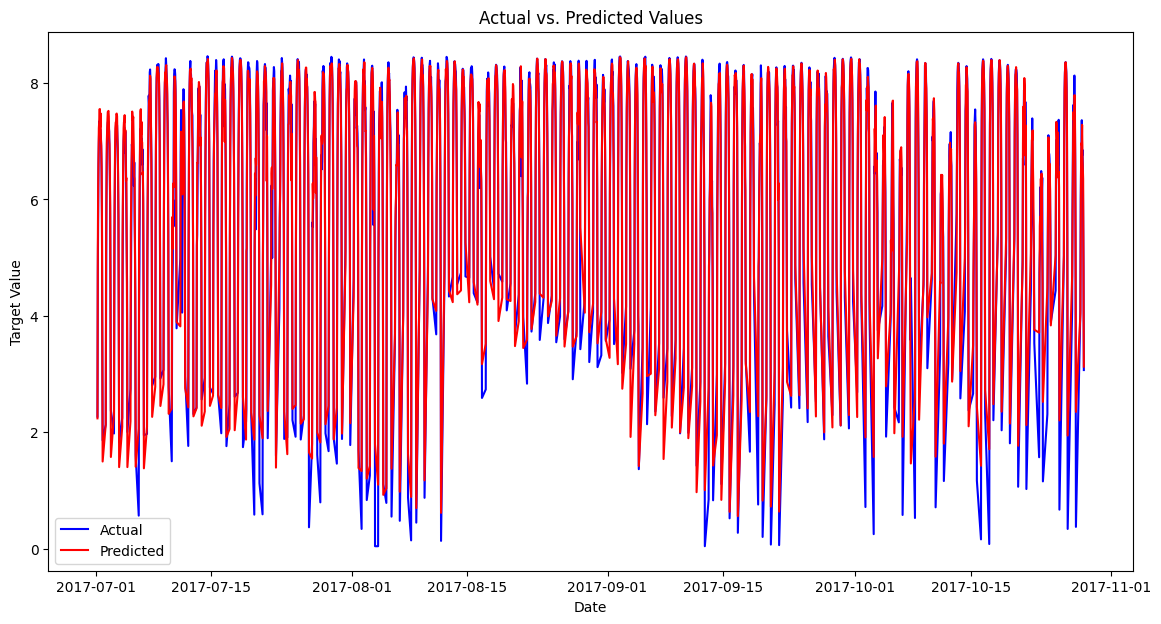

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(test_set['ds'], y_test, label='Actual', color='blue')
plt.plot(test_set['ds'], y_pred, label='Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Target Value')
plt.title('Actual vs. Predicted Values')
plt.show()


# Prophet Model


In [ ]:
# print(train_set)
# print(test_set)

In [ ]:
best_rmse = float('inf')
for changepoint_prior in param_grid['changepoint_prior_scale']:
    for seasonality_prior in param_grid['seasonality_prior_scale']:
        # for seasonality_mode in param_grid['seasonality_mode']:
            # Initialize the Prophet model with current parameters
            model = Prophet(
                changepoint_prior_scale=changepoint_prior,
                seasonality_prior_scale=seasonality_prior,
                seasonality_mode=seasonality_mode,
                daily_seasonality=True
            )
            # Add custom seasonality
            model.add_seasonality(name='hourly', period=24, fourier_order=5)

            # Add regressors
            for regressor in important_features:
                model.add_regressor(regressor)

            # Fit the model on the training set
            model.fit(train_set)

            # Perform cross-validation
            df_cv = cross_validation(
                model,
                initial='365 days',  # Initial training period
                period='180 days',   # Frequency of testing
                horizon='30 days'    # Prediction horizon
            )

            # Compute performance metrics
            df_p = performance_metrics(df_cv)

            # Compare RMSE to find the best parameters
            mean_rmse = df_p['rmse'].mean()
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_params = {
                    'changepoint_prior_scale': changepoint_prior,
                    'seasonality_prior_scale': seasonality_prior,
                    # 'seasonality_mode': seasonality_mode
                }

print(f"Best Parameters: {best_params}")
print(f"Best RMSE on validation set: {best_rmse}")



In [ ]:
Best_Parameters_prophet = {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0}

In [ ]:
final_model_prophet = Prophet(**Best_Parameters_prophet, daily_seasonality=True,growth='flat')
final_model_prophet.add_seasonality(name='hourly', period=24, fourier_order=5)

for regressor in important_features:
    final_model_prophet.add_regressor(regressor)

final_model_prophet.fit(train_set)

forecast = final_model_prophet.predict(test_set)

from sklearn.metrics import mean_squared_error
from math import sqrt
test_rmse = sqrt(mean_squared_error(test_set['y'], forecast['yhat']))
print(f"Test RMSE: {test_rmse}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30hfmwp0/mh66f214.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp30hfmwp0/604f3hus.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4583', 'data', 'file=/tmp/tmp30hfmwp0/mh66f214.json', 'init=/tmp/tmp30hfmwp0/604f3hus.json', 'output', 'file=/tmp/tmp30hfmwp0/prophet_model0b070hna/prophet_model-20241215162935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:29:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:29:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test RMSE: 0.7004309842319058


In [ ]:
print(f"Mean of target: {train_set['y'].mean()}")
print(f"Standard deviation of target: {train_set['y'].std()}")

test_std = test_set['y'].std()
nrmse_test = test_rmse / test_std
print(f"Normalized RMSE: {nrmse_test:.2%}")

Mean of target: 6.418646106790386
Standard deviation of target: 1.9243621584632715
Normalized RMSE: 36.11%


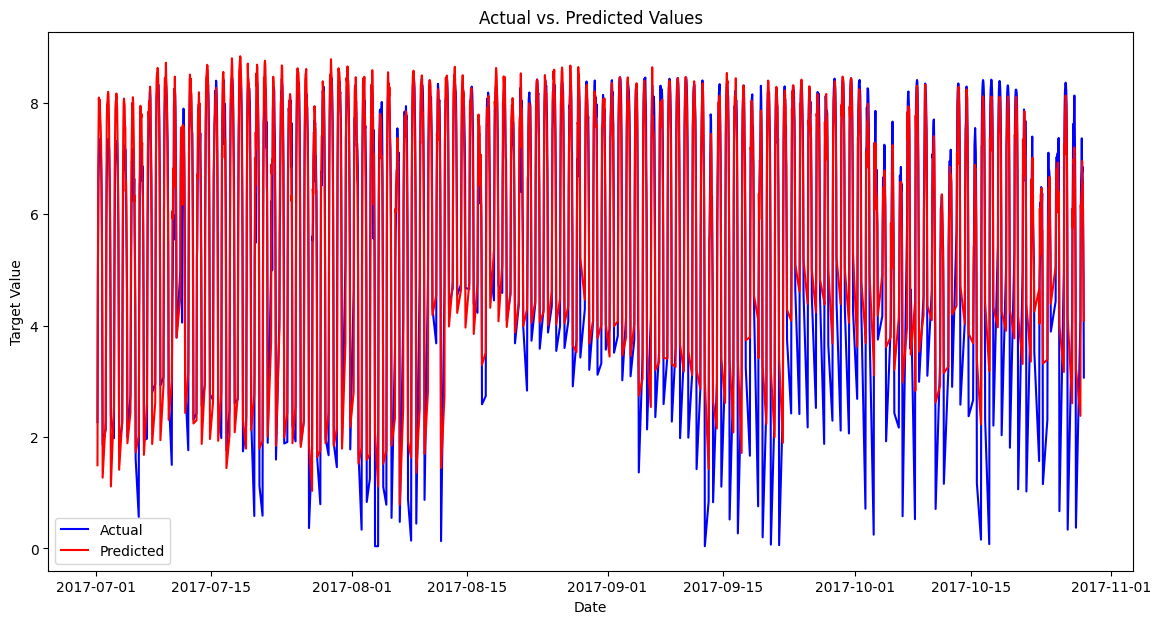

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(test_set['ds'], test_set['y'], label='Actual', color='blue')
plt.plot(test_set['ds'], forecast['yhat'], label='Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Target Value')
plt.title('Actual vs. Predicted Values')
plt.show()


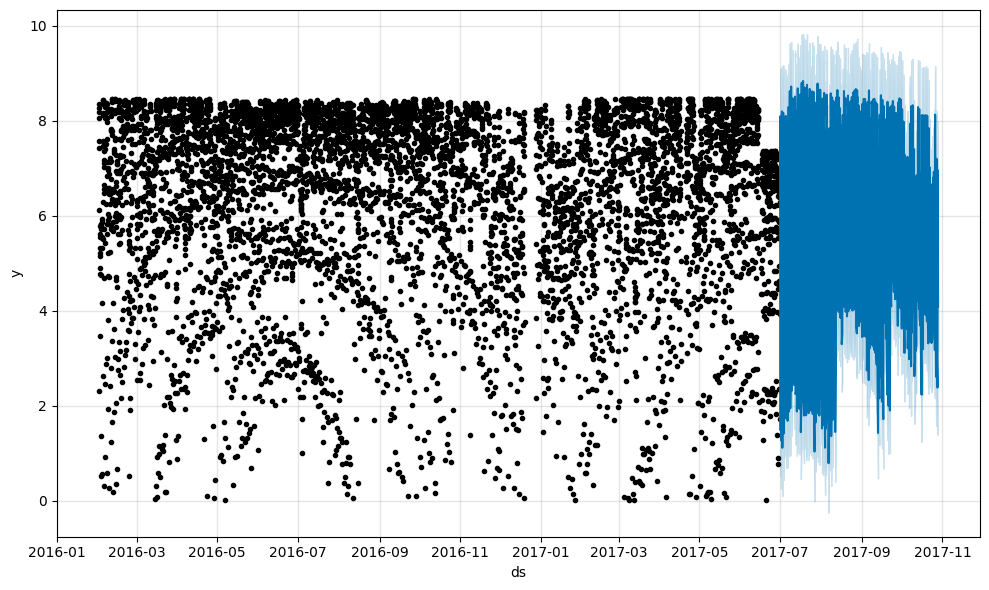

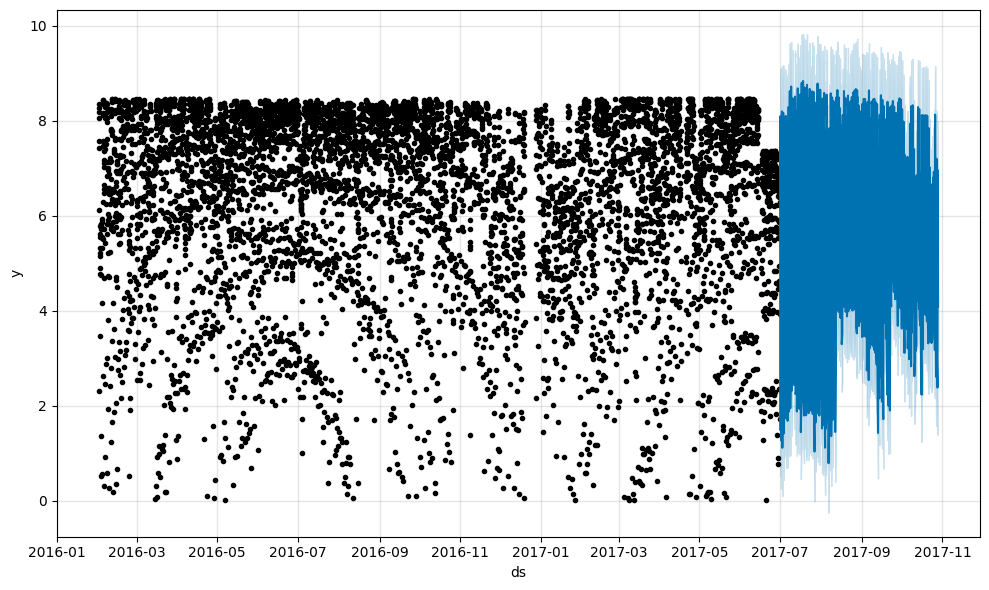

In [ ]:
final_model_prophet.plot(forecast)

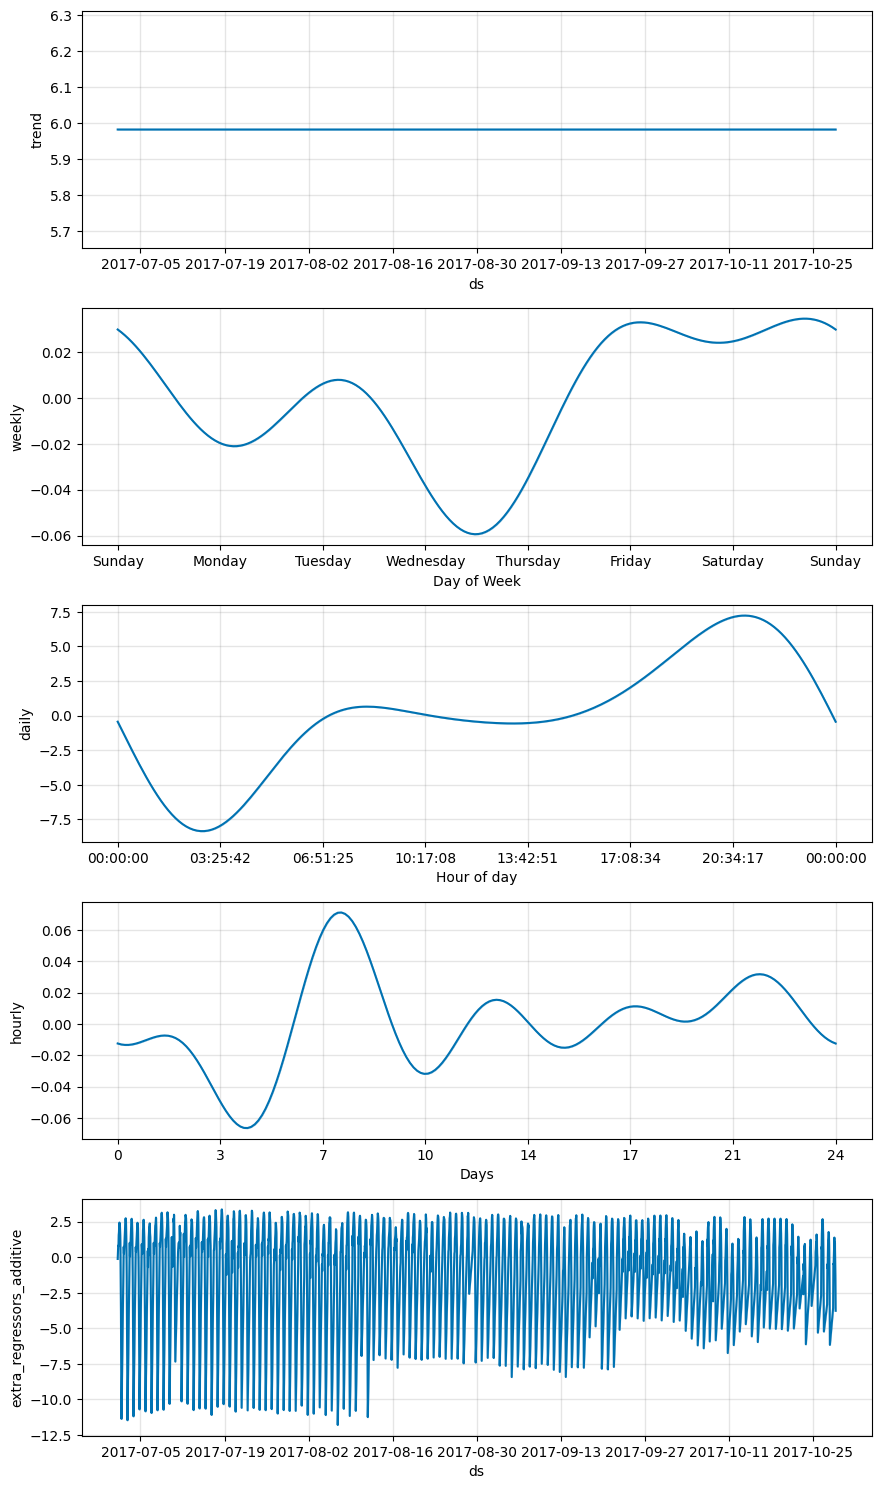

In [ ]:
fig = final_model_prophet.plot_components(forecast)
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    print(mape)


In [ ]:
mean_absolute_percentage_error(test_set['y'],forecast['yhat'])

36.27653453367889


# Dumping Model and Scalers


In [ ]:
joblib.dump(final_model_prophet,'prophet_model.joblib')
joblib.dump(best_rf,'rfr_model.joblib')
joblib.dump(standard_scaler,'standard_scaler.joblib')
joblib.dump(min_max_scaler,'min_max_scaler.joblib')

['min_max_scaler.joblib']

In [ ]:
files.download('prophet_model.joblib')
files.download('rfr_model.joblib')
files.download('standard_scaler.joblib')
files.download('min_max_scaler.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>